In [1]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

# Error 1: Recalculate stderr transition matrix

In [2]:
def stderr_tril_qcut(df, q, cusips):
    
    # get particular cusips
    data = df.loc[cusips][cusips].values
    lower_tri = data[np.tril_indices(len(data), k=-1)]
    
    # get stderr of data
    stderrs = (lower_tri - np.mean(lower_tri)) / np.std(lower_tri)
    
    # build bins
    # NOTE: we'll ALWAYS need the <-2 and >2 bins, since otherwise the things aren't comparable
    intervals = [pd.Interval(elt, elt + 0.5) for elt in np.arange(-2, 2, 0.5)]
    intervals = [pd.Interval(-np.inf, -2)] + intervals + [pd.Interval(2, np.inf)]    
    intervals = pd.IntervalIndex(intervals)
    
    discretized = pd.cut(stderrs, intervals, include_lowest=True)
    labels = range(1, len(discretized.categories) + 1)
    return pd.Series(discretized.rename_categories(labels)).astype(int)

def tril_qcut(df, q, cusips):
    
    # get particular cusips
    data = df.loc[cusips][cusips].values
    lower_tri = data[np.tril_indices(len(data), k=-1)]
    
    # NOTE: we're using straight qcut here, so high correlations will be in high quantiles
    return pd.qcut(lower_tri, q, labels=range(1, q + 1))

In [3]:
def get_transition_matrix(periods, n_quantiles, stderr=False):
    transition_matrix = np.zeros((n_quantiles + 1, n_quantiles + 1))
    periods = periods[:-2]
    n_decades = len(periods) // 20

    for per_idx in range(len(periods) - 1):
        
        # read in correlation matrices
        print(f'Adding period {periods[per_idx][0]}...')
        clear_output(wait=True)
        iter_start = datetime.now()
        current_corr = pd.read_csv(f'wrds_results/corr_dump/{periods[per_idx][0]}_corr.csv', index_col=0)
        next_corr = pd.read_csv(f'wrds_results/corr_dump/{periods[per_idx + 1][0]}_corr.csv', index_col=0)
        
        # fix weird string/float error
        current_corr.index = current_corr.index.astype('string')
        next_corr.index = next_corr.index.astype('string')
        
        # determine overlap & get data
        cusips = current_corr.index[current_corr.index.isin(next_corr.index)]

#         try:
        
        if stderr:
            current_q = stderr_tril_qcut(current_corr, n_quantiles, cusips)
            next_q = stderr_tril_qcut(next_corr, n_quantiles, cusips)
        else:
            current_q = tril_qcut(current_corr, n_quantiles, cusips)
            next_q = tril_qcut(next_corr, n_quantiles, cusips)
        
        # build transition matrix
        for j in range(len(current_q)):
            transition_matrix[current_q[j]][next_q[j]] += 1
            
        print(f'Period {periods[per_idx][0]} complete in {str(datetime.now() - iter_start)}')

        
    # normalize transition matrix
    overall_matrix = transition_matrix
    
    for i in range(n_quantiles + 1):
        mat_sum = np.sum(overall_matrix[i])
        if mat_sum > 0:
            overall_matrix[i] /= mat_sum
            
    return overall_matrix

In [4]:
# setup for wrds data
def get_days(start_dt, end_dt):
    nyse = mcal.get_calendar('NYSE')
    return [day.date() for day in nyse.valid_days(start_date=str(start_dt), 
                                                end_date=str(end_dt))]

def get_weeks(start_dt, end_dt):
    weeks = []

    # get trading days and divide into weeks, rolling over on the given rollover day
    current_week = []
    days = get_days(start_dt, end_dt)
    for i, day in enumerate(days):
        # append to current week
        current_week.append(day)

        #end of the week check
        if i+1<len(days):
            next_day = days[i+1]
            if next_day.weekday() < day.weekday(): #if the next day's weekday comes before the current, then the next_day is in a new week
                weeks.append(current_week)
                current_week = []
            elif (next_day-day).days > 4: #if the condition above didnt pass, check that >4 days didnt pass as well
                weeks.append(current_week)
                current_week = []

    # append final week, even if it wasn't a full week period
    if current_week: weeks.append(current_week)

    return weeks

def get_periods(weeks):
    periods = []
    start_date = weeks[0][0]
    end_date = None
    for i in range(len(weeks)-1):
        start = weeks[i][0] #this monday
        end = weeks[i][-1]  #this friday

        next_start = weeks[i+1][0] #next monday
        next_end = weeks[i+1][-1]  #next friday

        #if the current friday is in december, and the next weeks friday is in january, this is the end of one period
        #the very next week will be the very start of the period\
        if end.month == 12 and next_end.month == 1:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
        #if the last day is in june, and the next weeks last day is in july, this is the end of one period
        #the very next week will be the very start of the period
        if end.month == 6 and next_end.month == 7:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
    periods.append([start_date, weeks[i+1][-1]])
    for i in periods:
        i[1] += timedelta(days=3)
    return periods

def periodToStr(period):
    return period[0].strftime("%m/%d/%Y") + " - " + period[1].strftime("%m/%d/%Y")

In [5]:
start_dt = date(1950, 1, 1)
end_dt = date(2021, 1, 1)
periods = get_periods(get_weeks(start_dt, end_dt))
exec_start = datetime.now()
transition_matrix = get_transition_matrix(periods, 10, stderr=True)
print(f'Done in {str(datetime.now() - exec_start)}')

Period 2018-12-31 complete in 0:03:00.357678
Done in 4:46:13.437483


In [6]:
print(f'Done at {str(datetime.now())}')

Done at 2022-04-19 06:24:19.145853


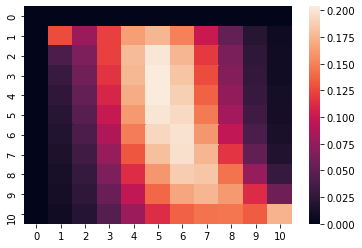

In [7]:
sns.heatmap(transition_matrix)
plt.show()